### Importing required modules

In [1]:
### Importing basic libraries
import numpy as np
import torch
from matplotlib import pyplot as plt
import random
from scipy.signal import butter, sosfiltfilt
import os
import pickle

### Importing torch related libraries
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

import os
os.chdir("..")
print("Current directory:", os.getcwd())

### Importing Custom Libraries
from lib.DTnet import SmallIncUNet
from lib.plot_utils import plot_filter_result
from lib.plot_utils import visualize_ecg_and_peaks
from lib.metrics import compute_peak_mae_on_loader
from lib.plot_utils import visualize_peak_detection
from lib.metrics import summary_per_subject
from lib.plot_utils import visualize_predictions

Current directory: /home/andrea/EEG-Rpeaks


In [2]:
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)
preproc_path = os.path.join(cache_dir, "data_preprocessed_full.pkl")

duration_sec = 10
frequency = 500

use_hr_band_filter = True
lowcut=5
highcut=22.5

subj_all = [29, 40,  27, 28, 30, 33, 35, 36, 39, 45, 47, 49, 52, 57, 58, 62,  66, 69, 71, 73, 76, 82, 84, 88, 89, 90, 93, 95, 97, 98, 99, 100, 101, 103, 104,  ]  #  41  118 107 23, 63,  64, 105, 113, 117, 119, 120, 121,  106,  109, 110, 111,  112

test_subj = subj_all[0:10]
val_subj = subj_all[10:15]
train_subjects = [s for s in subj_all if s not in test_subj and s not in val_subj]

use_augmentation = True
warp_factor_range = (0.8, 1.2)
aug_segment_duration = int(np.ceil(warp_factor_range[1] * duration_sec)) + 1  # Add buffer for warping
n_augmented_per_segment = 10
train_overlap = 0.0

BATCH_SIZE = 32
C, H, W = 128, 1, 5000
learn_rate = 1e-3
weight_decay = 1e-4
num_epochs = 50

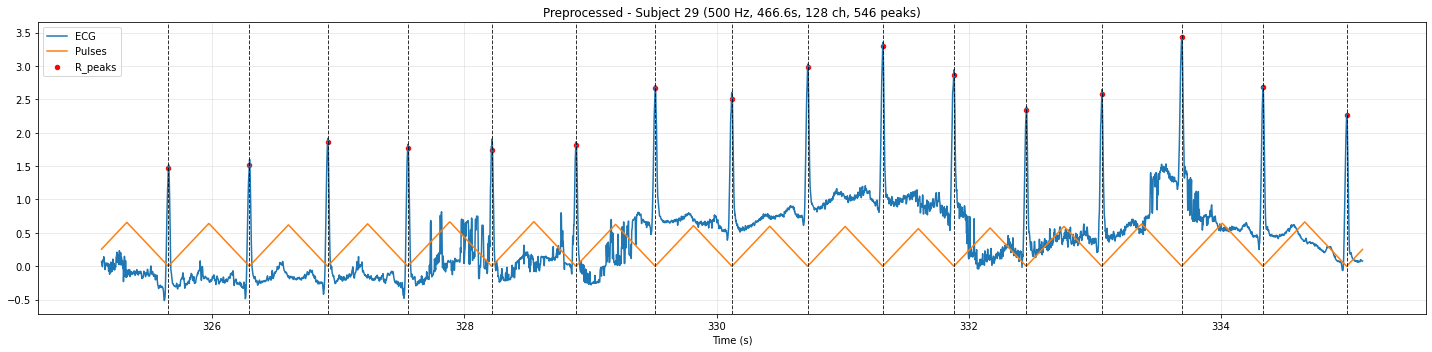

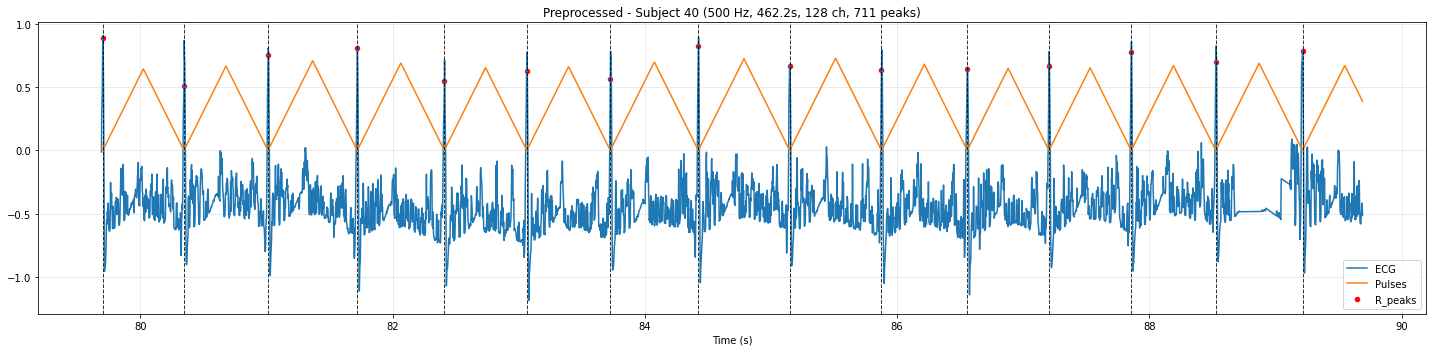

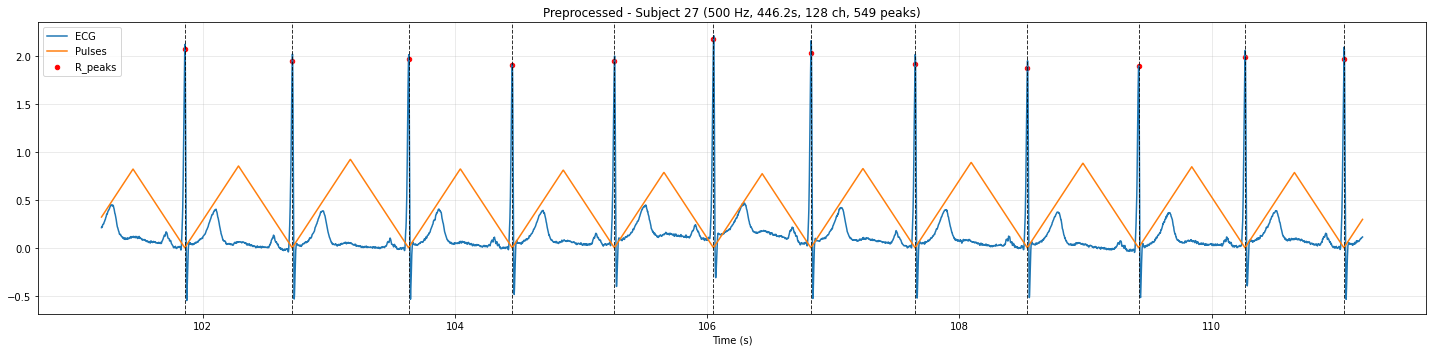

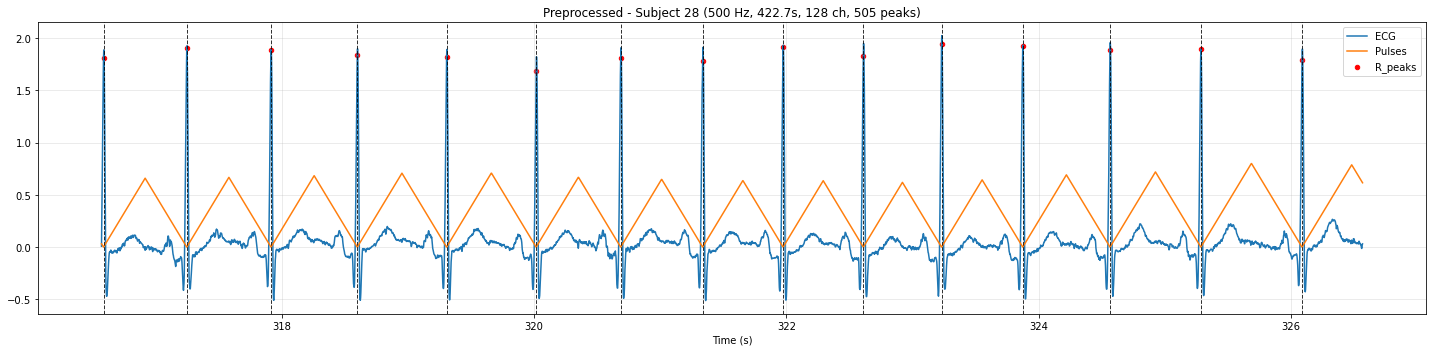

In [3]:
def bandpass_eeg(x, fs, lowcut=0.1, highcut=22.5, order=4):
    nyq = fs / 2.0
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sosfiltfilt(sos, x, axis=-1)

'''
 Preprocess data structure: {
        'ECG': ECG,
        'ECG_pulse': ECG_pulse,
        'R_peaks': R_peaks,
        'EEG': EEG,
        'time': time,
        'freq': freq }
 '''

with open(preproc_path, "rb") as f:
    data_preprocessed = pickle.load(f)

if use_hr_band_filter:
    for ss in subj_all:
        fs_ds = frequency
        eeg_unfilt = np.asarray(data_preprocessed[ss]['EEG'], dtype=float)
        data_preprocessed[ss]['EEG_unfilt'] = eeg_unfilt
        data_preprocessed[ss]['EEG'] = bandpass_eeg(eeg_unfilt, fs_ds, lowcut=lowcut, highcut=highcut)


def compute_R_distance_next(r_peaks, sig_len):
    r_peaks = np.asarray(r_peaks, dtype=int)
    dist = np.full(sig_len, np.nan, dtype=float)

    for i in range(r_peaks.size - 1):
        a = r_peaks[i]
        b = r_peaks[i + 1]
        if b <= a:
            continue
        seg = np.arange(a, b + 1)
        left = seg - a
        right = b - seg
        min_dist = np.minimum(left, right).astype(float)  # 0..(b-a)/2
        interval = float(b - a)  # interval length in samples
        # We want midpoint value == interval (distance to next peak)
        # min_dist at midpoint == interval/2, so multiply by 2:
        values = 2.0 * min_dist  # ranges 0 .. interval
        dist[a:b+1] = values

    # before first peak: use interval to next peak
    first = r_peaks[0]
    if first > 0:
        next_interval = float(r_peaks[1] - r_peaks[0]) if r_peaks.size > 1 else float(sig_len)
        seg = np.arange(0, first)
        # distance to next peak decreases as we approach the peak: use (first - pos)
        d = first - seg  # ranges next_interval..1 (but might be > next_interval if first large)
        # Clip to next_interval so far-away values don't exceed the interval value
        values = np.minimum(d, next_interval)
        # But to be consistent with interior segments shape, scale so maximum equals next_interval
        # If we want linear from 0 at first to next_interval at far left:
        if first > 0:
            values = (d / float(first)) * next_interval
        dist[0:first] = values

    # after last peak: use interval to previous peak
    last = r_peaks[-1]
    if last < sig_len - 1:
        prev_interval = float(r_peaks[-1] - r_peaks[-2]) if r_peaks.size > 1 else float(last + 1)
        seg = np.arange(last + 1, sig_len)
        d = seg - last  # 1..(sig_len-last-1)
        if (sig_len - 1 - last) > 0:
            values = (d / float(sig_len - 1 - last)) * prev_interval
        else:
            values = np.minimum(d, prev_interval)
        dist[last+1:] = values

    return dist


for ss in subj_all:
    r_peaks = data_preprocessed[ss].get('R_peaks', [])
    sig_len = int(np.asarray(data_preprocessed[ss]['ECG']).shape[-1])
    data_preprocessed[ss]['ECG_pulse'] = compute_R_distance_next(r_peaks, sig_len) / frequency  # distance in second

# Visualize parsed data
for i, ss in enumerate(subj_all):
    visualize_ecg_and_peaks(ss, None, data_preprocessed[ss], duration_sec)
    if i > 2:
        break

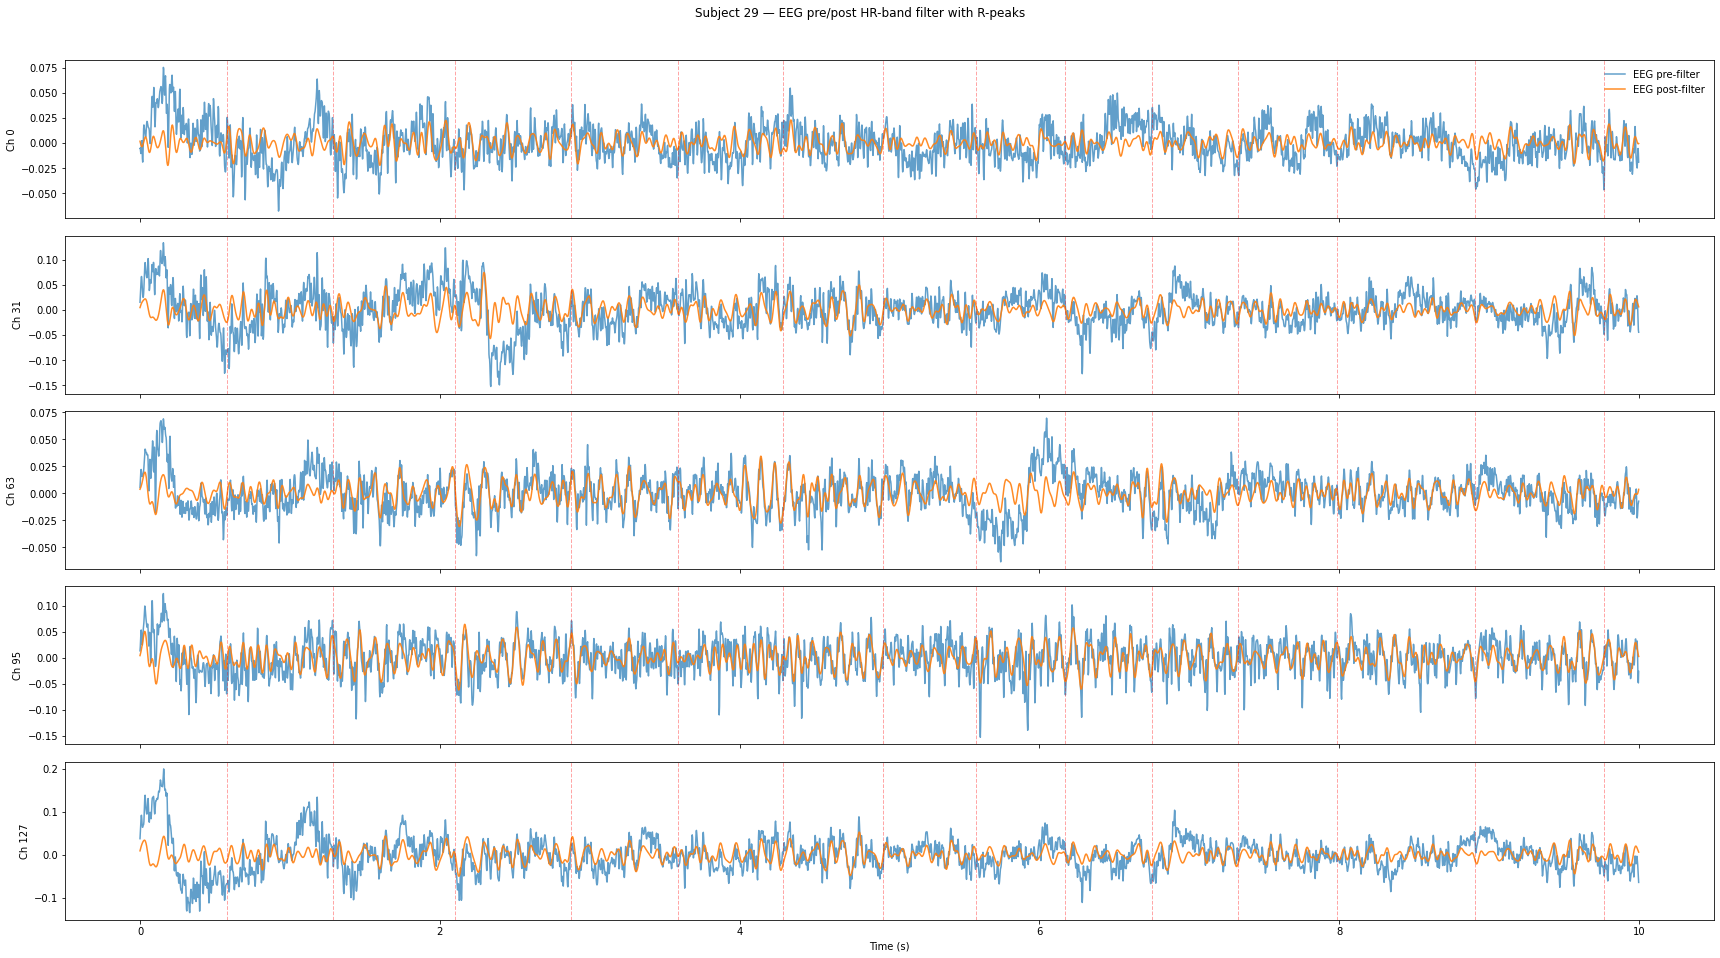

In [4]:
plot_subj = test_subj[0]
plot_filter_result(data_preprocessed, duration_sec, plot_subj)

In [5]:
import numpy as np
from lib.dataset_utils import augment_segment, create_segments_nonoverlapping, create_segments_sliding, create_training_segments_with_augmentation


def create_training_segments_with_augmentation(subject_data, aug_seg_len, seg_len, stride, warp_range, n_aug):
    """Create training segments with augmentation."""
    EEG = subject_data['EEG']
    pulse = subject_data['ECG_pulse']
    ECG = subject_data['ECG']
    
    # Create larger segments
    X_large, y_large, ecg_large = create_segments_sliding(EEG, pulse, ECG, aug_seg_len, stride)

    # Extract the original seg_len segments, centered from aug_seg_len segments
   # center_offset = (aug_seg_len - seg_len) // 2
   # X_orig = X_large[:, center_offset:center_offset + seg_len, :]
   # y_orig = y_large[:, center_offset:center_offset + seg_len]
   # ecg_orig = ecg_large[:, center_offset:center_offset + seg_len]
    
    # Create augmented versions
    X_aug_list, y_aug_list, ecg_aug_list = [], [], []
    for i in range(len(X_large)):
        augs = augment_segment(X_large[i], y_large[i], ecg_large[i], seg_len, warp_range, n_aug)
        for aug in augs:
            X_aug_list.append(aug['eeg'])
            y_aug_list.append(aug['pulse'])
            ecg_aug_list.append(aug['ecg'])
    
    X_all = np.stack(X_aug_list, axis=0)
    y_all = np.stack(y_aug_list, axis=0)
    ecg_all = np.stack(ecg_aug_list, axis=0)

    return X_all, y_all, ecg_all



def process_subjects(subjects, data_preprocessed, seg_len, stage, **aug_params):
    """Process subjects and create segments."""
    X_list, y_list, ecg_list, ids_list = [], [], [], []
    
    for subj_id in subjects:        
        # Choose segmentation method
        if stage == 'training' and aug_params.get('use_augmentation'):
            X, y, ecg = create_training_segments_with_augmentation(
                data_preprocessed[subj_id], 
                aug_params['aug_seg_len'], 
                seg_len, 
                aug_params['train_stride'],
                aug_params['warp_factor_range'], 
                aug_params['n_augmented_per_segment']
            )
        elif stage == 'training':
            X, y, ecg = create_segments_sliding(
                data_preprocessed[subj_id]['EEG'],
                data_preprocessed[subj_id]['ECG_pulse'],
                data_preprocessed[subj_id]['ECG'],
                seg_len, aug_params['train_stride']
            )
        else:
            X, y, ecg = create_segments_nonoverlapping(
                data_preprocessed[subj_id]['EEG'],
                data_preprocessed[subj_id]['ECG_pulse'],
                data_preprocessed[subj_id]['ECG'],
                seg_len
            )
        
        X_list.append(X)
        y_list.append(y)
        ecg_list.append(ecg)
        ids_list.append(np.full(X.shape[0], subj_id, dtype=np.int32))
    
    return X_list, y_list, ecg_list, ids_list


# Calculate parameters
seg_len = int(duration_sec * frequency)
aug_seg_len = int(aug_segment_duration * frequency) if use_augmentation else seg_len
train_stride = max(1, int(seg_len * (1.0 - train_overlap)))
n_channels = data_preprocessed[subj_all[0]]['EEG'].shape[0]

# Process all splits
aug_params = {
    'use_augmentation': use_augmentation,
    'aug_seg_len': aug_seg_len,
    'train_stride': train_stride,
    'warp_factor_range': warp_factor_range,
    'n_augmented_per_segment': n_augmented_per_segment
}

X_train_list, y_train_list, ecg_train_list, train_ids = process_subjects(train_subjects, data_preprocessed, seg_len, 'training', **aug_params)
X_val_list, y_val_list, ecg_val_list, val_ids = process_subjects(val_subj, data_preprocessed, seg_len, 'validation', **aug_params)
X_test_list, y_test_list, ecg_test_list, test_ids = process_subjects(test_subj, data_preprocessed, seg_len, 'test', **aug_params)

# Concatenate all
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
ECG_train = np.concatenate(ecg_train_list, axis=0)
train_seg_subjects = np.concatenate(train_ids, axis=0)

X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)
ECG_val = np.concatenate(ecg_val_list, axis=0)
val_seg_subjects = np.concatenate(val_ids, axis=0)

X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)
ECG_test = np.concatenate(ecg_test_list, axis=0)
test_seg_subjects = np.concatenate(test_ids, axis=0)


def scale_window_standard(x_win):
    # x_win: (channels, window_len) -> z-score per channel
    mean = x_win.mean(axis=1, keepdims=True)
    std = x_win.std(axis=1, keepdims=True) + 1e-8
    return (x_win - mean) / std

X_train = scale_window_standard(X_train)
X_val = scale_window_standard(X_val)
X_test = scale_window_standard(X_test)


# Summary
print(f"Final dataset:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")

Final dataset:
  Train: (8780, 5000, 128)
  Val:   (213, 5000, 128)
  Test:  (453, 5000, 128)


# Train and Evaluate #

### Loading data via the pt files

In [6]:
# Create PyTorch datasets and loaders
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
ECG_train_t = torch.from_numpy(ECG_train.astype(np.float32))

X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val.astype(np.float32))
ECG_val_t = torch.from_numpy(ECG_val.astype(np.float32))

X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))
ECG_test_t = torch.from_numpy(ECG_test.astype(np.float32))

train_subj_t = torch.from_numpy(train_seg_subjects.astype(np.int64))
val_subj_t = torch.from_numpy(val_seg_subjects.astype(np.int64))
test_subj_t = torch.from_numpy(test_seg_subjects.astype(np.int64))

y_train_t = y_train_t.unsqueeze(1)
y_val_t = y_val_t.unsqueeze(1)
y_test_t = y_test_t.unsqueeze(1)

# Include ECG and subject IDs in the datasets
train_ds = TensorDataset(X_train_t, y_train_t, ECG_train_t, train_subj_t)
val_ds = TensorDataset(X_val_t, y_val_t, ECG_val_t, val_subj_t)
test_ds = TensorDataset(X_test_t, y_test_t, ECG_test_t, test_subj_t)

trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) 
testloader = DataLoader(test_ds, batch_size=64, shuffle=False)
valloader = DataLoader(val_ds, batch_size=64, shuffle=False)

print(f"Created data loaders with training batch_size={BATCH_SIZE}")
print(X_train_t.shape, y_train_t.shape)
print(X_val_t.shape, y_val_t.shape)
print(X_test_t.shape, y_test_t.shape)

Created data loaders with training batch_size=32
torch.Size([8780, 5000, 128]) torch.Size([8780, 1, 5000])
torch.Size([213, 5000, 128]) torch.Size([213, 1, 5000])
torch.Size([453, 5000, 128]) torch.Size([453, 1, 5000])


### Ensuring deterministicity through Random seeding


In [7]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
manualSeed = 4
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed) 

### Setting the optimizer and Loss function

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SmallIncUNet(in_shape = (C,H,W)).to(device)
optimizer = optim.Adam(model.parameters(), lr=learn_rate, weight_decay=weight_decay)

# Use peak-based MAE for LR reduction
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10)
criterion = nn.SmoothL1Loss()

summary(model, input_size=(1, seg_len, n_channels), col_names=["input_size", "output_size", "num_params"], depth=4)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SmallIncUNet                             [1, 5000, 128]            [1, 1, 5000]              --
├─Sequential: 1-1                        [1, 128, 5000]            [1, 32, 2500]             --
│    └─Conv1d: 2-1                       [1, 128, 5000]            [1, 32, 2500]             16,416
│    └─BatchNorm1d: 2-2                  [1, 32, 2500]             [1, 32, 2500]             64
│    └─LeakyReLU: 2-3                    [1, 32, 2500]             [1, 32, 2500]             --
│    └─IncResBlock: 2-4                  [1, 32, 2500]             [1, 32, 2500]             --
│    │    └─Conv1d: 3-1                  [1, 32, 2500]             [1, 32, 2500]             1,024
│    │    └─Sequential: 3-2              [1, 32, 2500]             [1, 8, 2500]              --
│    │    │    └─Conv1d: 4-1             [1, 32, 2500]             [1, 8, 2500]              3,848
│    │    │    └─BatchNor

### Training ###

In [ ]:
epoch_loss, test_epoch_loss, val_epoch_loss = [], [], []
f1_val_history, f1_train_history, f1_test_history = [], [], []
disc_f1_val_history, disc_f1_train_history, disc_f1_test_history = [], [], []
disc_p_val_history, disc_p_train_history, disc_p_test_history = [], [], []
disc_r_val_history, disc_r_train_history, disc_r_test_history = [], [], []

max_val_f1 = 0
best_epoch = 0
patience_counter = 0
early_stop_patience = 20


for epoch in range(num_epochs):
    model.train()
    net_loss_sum = 0.0
    for step,(x,y,ecg,subj_ids) in enumerate(trainloader):  
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        net_loss_sum += loss.item()
    train_loss_scalar = net_loss_sum / (step + 1)
    epoch_loss.append(train_loss_scalar)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        net_test_sum = 0.0
        for step,(x,y,ecg,subj_ids) in enumerate(testloader): 
            x = x.to(device)
            y = y.to(device)
            y_pred_t = model(x)
            test_loss = criterion(y_pred_t, y)
            net_test_sum += test_loss.item()
        test_loss_scalar = net_test_sum / (step + 1)
    test_epoch_loss.append(test_loss_scalar)
    
    # Evaluate on validation set (loss-based)
    with torch.no_grad():
        net_val_sum = 0.0
        for step,(x,y,ecg,subj_ids) in enumerate(valloader):  
            x = x.to(device)
            y = y.to(device)
            y_pred_v = model(x)
            val_loss = criterion(y_pred_v, y)
            net_val_sum += val_loss.item()
        val_loss_scalar = net_val_sum / (step + 1)
    val_epoch_loss.append(val_loss_scalar)
    
    # Compute peak-based MAE on validation set
    val_peak_mae, _val_num_matches, val_precision, val_recall, val_f1, mrr_err_val, prr50_err_val, sdrr_err_val, rmssd_err_val, disc_p_val, disc_r_val, disc_f1_val  = compute_peak_mae_on_loader(valloader, model, device, height_threshold=-0.21)
    f1_val_history.append(val_f1)
    disc_f1_val_history.append(disc_f1_val)
    disc_p_val_history.append(disc_p_val)
    disc_r_val_history.append(disc_r_val)
    
    # Use peak-based MAE for scheduler and early stopping
    if not np.isnan(val_f1):
        scheduler.step(1-val_f1)

    # Compute peak-based MAE on validation set
    train_peak_mae, _num_matches, train_precision, train_recall, train_f1, mrr_err_train, prr50_err_train, sdrr_err_train, rmssd_err_train, disc_p_train, disc_r_train, disc_f1_train = compute_peak_mae_on_loader(trainloader, model, device, height_threshold=-0.21)
    f1_train_history.append(train_f1)
    disc_f1_train_history.append(disc_f1_train)
    disc_p_train_history.append(disc_p_train)
    disc_r_train_history.append(disc_r_train)

    # Compute peak-based MAE on validation set
    test_peak_mae, _num_matches, test_precision, test_recall, test_f1, mrr_err_test, prr50_err_test, sdrr_err_test, rmssd_err_test, disc_p_test, disc_r_test, disc_f1_test = compute_peak_mae_on_loader(testloader, model, device, height_threshold=-0.21)
    f1_test_history.append(test_f1)
    disc_f1_test_history.append(disc_f1_test)
    disc_p_test_history.append(disc_p_test)
    disc_r_test_history.append(disc_r_test)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Losses  Tr: {train_loss_scalar:.4f}  V: {val_loss_scalar:.4f}  Ts: {test_loss_scalar:.4f} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e}\n"
        f"Train | P: {train_precision:.2f} ({disc_p_train:.4f}%), R: {train_recall:.2f} ({disc_r_train:.4f}%), F1: {train_f1:.4f} ({disc_f1_train:.4f}%), "
        f"MAE: {train_peak_mae:.4f}, mRR_err: {mrr_err_train:.2f}%, "
      #  f"pRR50_err: {prr50_err_train:.2f}%, SDRR_err: {sdrr_err_train:.2f}%, RMSSD_err: {rmssd_err_train:.2f}%\n"
        f"Val   | P: {val_precision:.2f} ({disc_p_val:.4f}%), R: {val_recall:.2f} ({disc_r_val:.4f}%), F1: {val_f1:.4f} ({disc_f1_val:.4f}%), "
        f"MAE: {val_peak_mae:.4f}, mRR_err: {mrr_err_val:.2f}%, "
     #   f"pRR50_err: {prr50_err_val:.2f}%, SDRR_err: {sdrr_err_val:.2f}%, RMSSD_err: {rmssd_err_val:.2f}%\n"
        f"Test  | P: {test_precision:.2f} ({disc_p_test:.4f}%), R: {test_recall:.2f} ({disc_r_test:.4f}%), F1: {test_f1:.4f} ({disc_f1_test:.4f}%), "
        f"MAE: {test_peak_mae:.4f}, mRR_err: {mrr_err_test:.2f}%, "
      #  f"pRR50_err: {prr50_err_test:.2f}%, SDRR_err: {sdrr_err_test:.2f}%, RMSSD_err: {rmssd_err_test:.2f}%"
    )

    # Save best model based on peak-based MAE
    if not np.isnan(val_f1) and disc_f1_val > max_val_f1:
        max_val_f1 = disc_f1_val
        best_epoch = epoch
        patience_counter = 0
        print(f'++++++++++++++++++++++++++++++++++')
        torch.save(model.state_dict(), 'saved_model/best_model.pt')
    else:
        patience_counter += 1
        print(f'---------------------------------- {patience_counter}/{early_stop_patience}')
    
    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break

print(f'\nTraining completed. Best val F1: {max_val_f1:.4f} at epoch {best_epoch+1}')
model.load_state_dict(torch.load('saved_model/best_model.pt'))

/home/andrea/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andrea/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/andrea/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/andrea/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/andrea/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 1/50 | Losses  Tr: 0.0381  V: 0.0295  Ts: 0.0261 | LR: 1.00e-03
Train | P: 0.32 (0.1700%), R: 0.05 (0.0215%), F1: 0.0766 (0.0369%), MAE: 0.1064, mRR_err: nan%, Val   | P: 0.30 (0.0978%), R: 0.05 (0.0126%), F1: 0.0710 (0.0219%), MAE: 0.1295, mRR_err: nan%, Test  | P: 0.34 (0.1709%), R: 0.05 (0.0225%), F1: 0.0857 (0.0386%), MAE: 0.1289, mRR_err: nan%, 
++++++++++++++++++++++++++++++++++
Epoch 2/50 | Losses  Tr: 0.0204  V: 0.0255  Ts: 0.0250 | LR: 1.00e-03
Train | P: 0.69 (0.5080%), R: 0.42 (0.3268%), F1: 0.4852 (0.3732%), MAE: 0.0908, mRR_err: nan%, Val   | P: 0.60 (0.3697%), R: 0.33 (0.2321%), F1: 0.3932 (0.2678%), MAE: 0.1445, mRR_err: nan%, Test  | P: 0.57 (0.2892%), R: 0.20 (0.1049%), F1: 0.2708 (0.1423%), MAE: 0.1470, mRR_err: nan%, 
++++++++++++++++++++++++++++++++++
Epoch 2/50 | Losses  Tr: 0.0204  V: 0.0255  Ts: 0.0250 | LR: 1.00e-03
Train | P: 0.69 (0.5080%), R: 0.42 (0.3268%), F1: 0.4852 (0.3732%), MAE: 0.0908, mRR_err: nan%, Val   | P: 0.60 (0.3697%), R: 0.33 (0.2321%), 

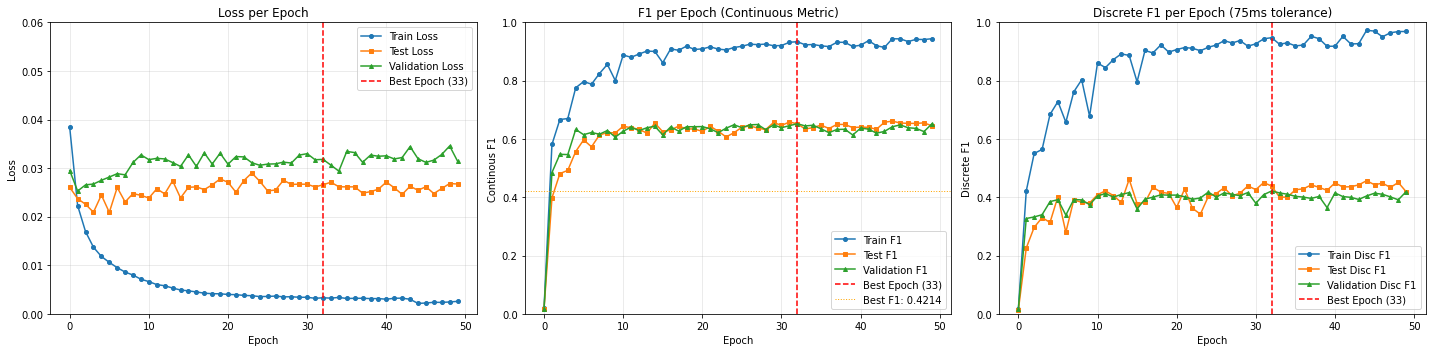

In [ ]:
# Plot training curves
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Loss curves
axes[0].plot(epoch_loss, label='Train Loss', marker='o', markersize=4)
axes[0].plot(test_epoch_loss, label='Test Loss', marker='s', markersize=4)
axes[0].plot(val_epoch_loss, label='Validation Loss', marker='^', markersize=4)
axes[0].axvline(x=best_epoch, color='red', linestyle='--', linewidth=1.5, label=f'Best Epoch ({best_epoch+1})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss per Epoch')
axes[0].grid(alpha=0.3)
axes[0].legend()
axes[0].set_ylim(0, max(0.06, max(epoch_loss[:3]) if len(epoch_loss) > 0 else 0.06))

# Continuous F1 curve
axes[1].plot(f1_train_history, label='Train F1', marker='o', markersize=4)
axes[1].plot(f1_test_history, label='Test F1', marker='s', markersize=4)
axes[1].plot(f1_val_history, label='Validation F1', marker='^', markersize=4)
axes[1].axvline(x=best_epoch, color='red', linestyle='--', linewidth=1.5, label=f'Best Epoch ({best_epoch+1})')
axes[1].axhline(y=max_val_f1, color='orange', linestyle=':', linewidth=1, label=f'Best F1: {max_val_f1:.4f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Continous F1')
axes[1].set_title('F1 per Epoch (Continuous Metric)')
axes[1].grid(alpha=0.3)
axes[1].legend()
axes[1].set_ylim(0, 1)

# Discrete F1 curve
axes[2].plot([f for f in disc_f1_train_history], label='Train Disc F1', marker='o', markersize=4)
axes[2].plot([f for f in disc_f1_test_history], label='Test Disc F1', marker='s', markersize=4)
axes[2].plot([f for f in disc_f1_val_history], label='Validation Disc F1', marker='^', markersize=4)
axes[2].axvline(x=best_epoch, color='red', linestyle='--', linewidth=1.5, label=f'Best Epoch ({best_epoch+1})')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Discrete F1')
axes[2].set_title('Discrete F1 per Epoch (75ms tolerance)')
axes[2].grid(alpha=0.3)
axes[2].legend()
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

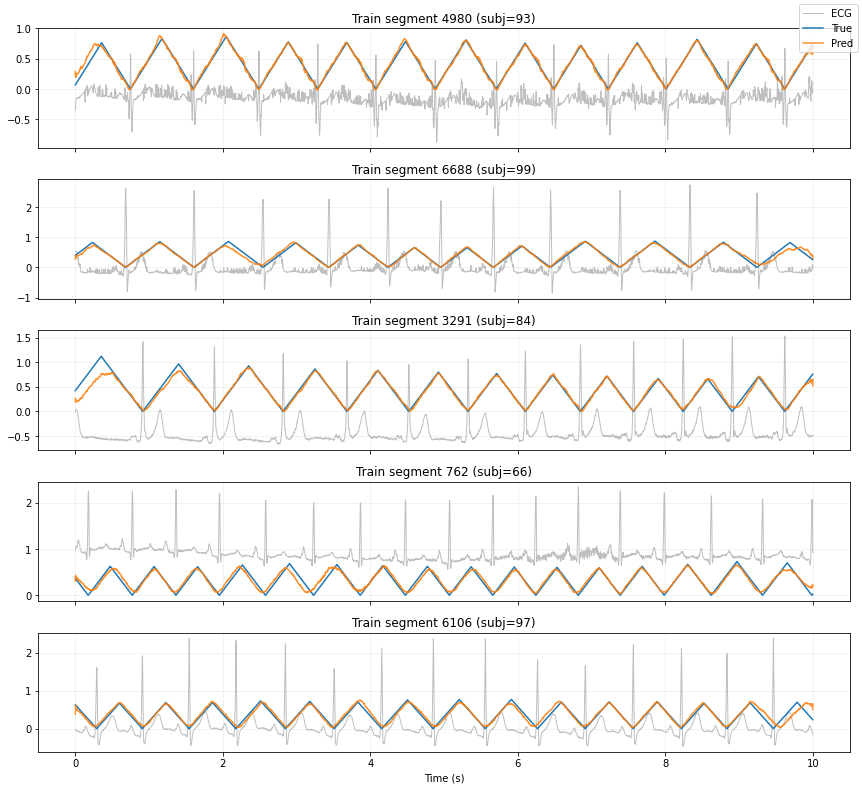

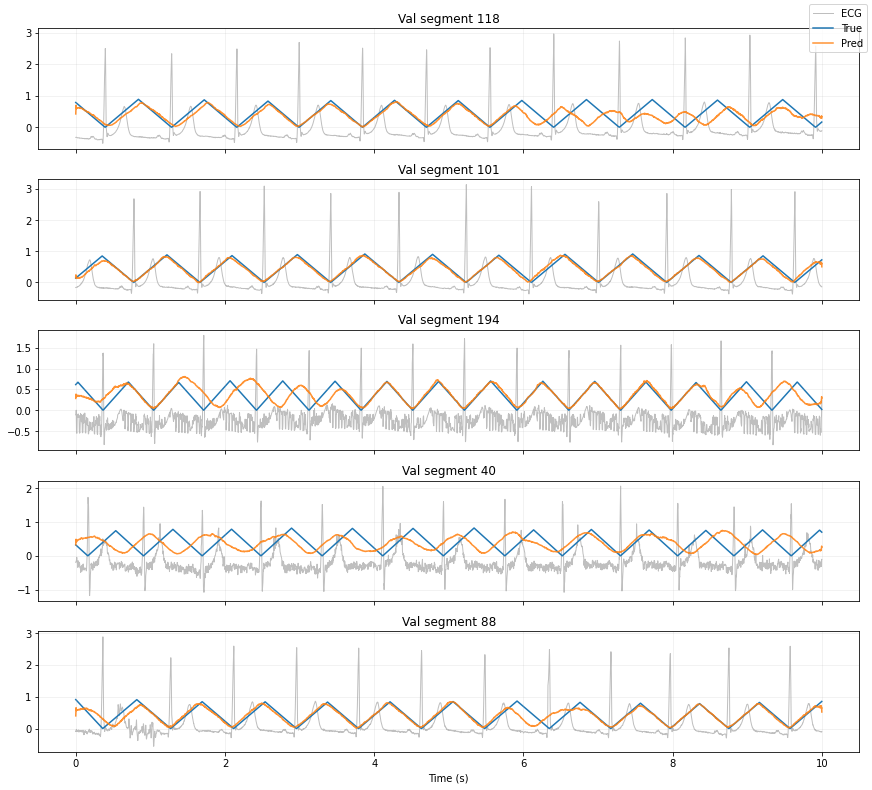

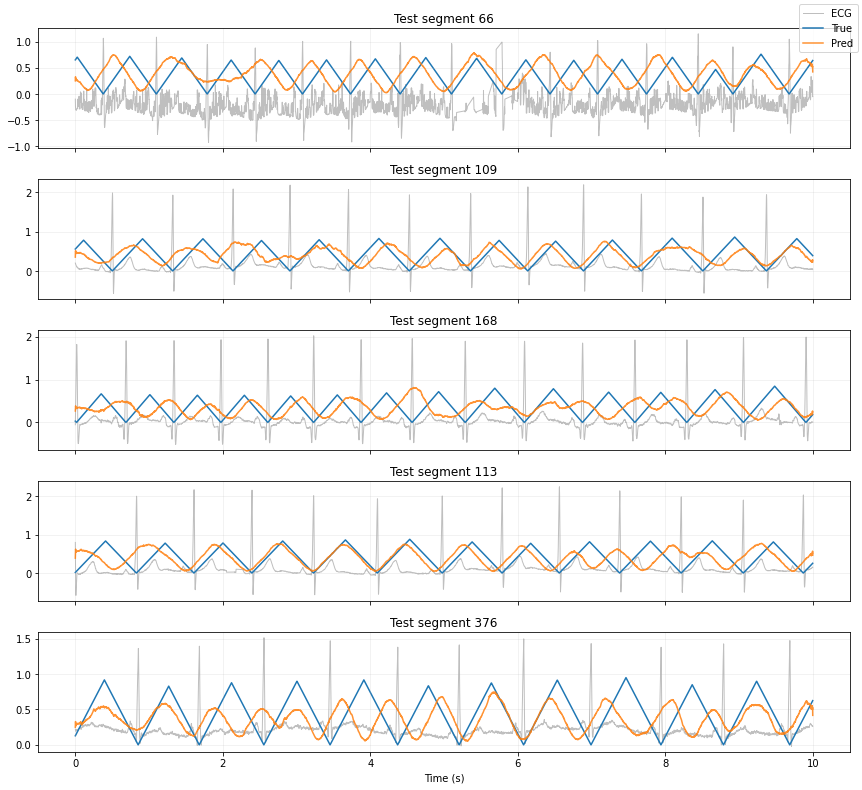

In [ ]:
visualize_predictions('Train', X_train, y_train, ECG_train, model, seg_len, frequency, device, train_seg_subjects, k=5)
visualize_predictions('Val', X_val, y_val, ECG_val, model, seg_len, frequency, device, k=5)
visualize_predictions('Test', X_test, y_test, ECG_test, model, seg_len, frequency, device, k=5)


TEST SET Peak Detection Examples:


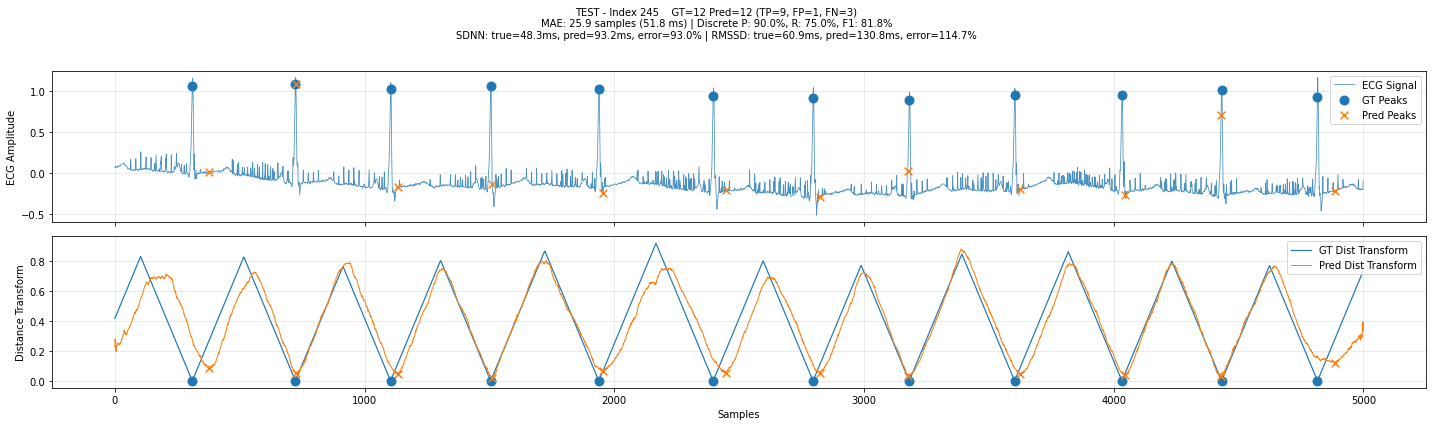

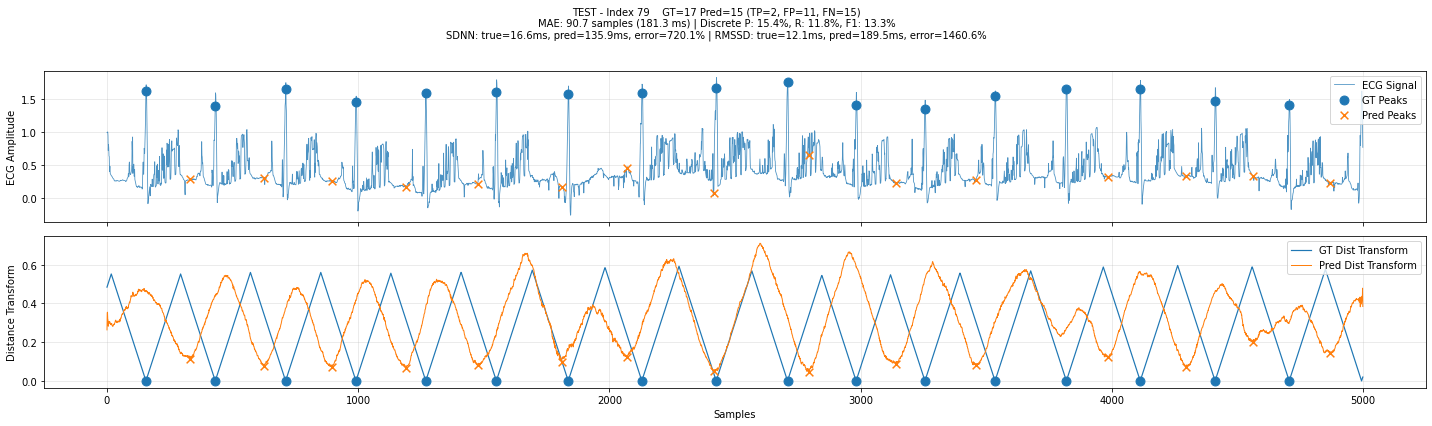

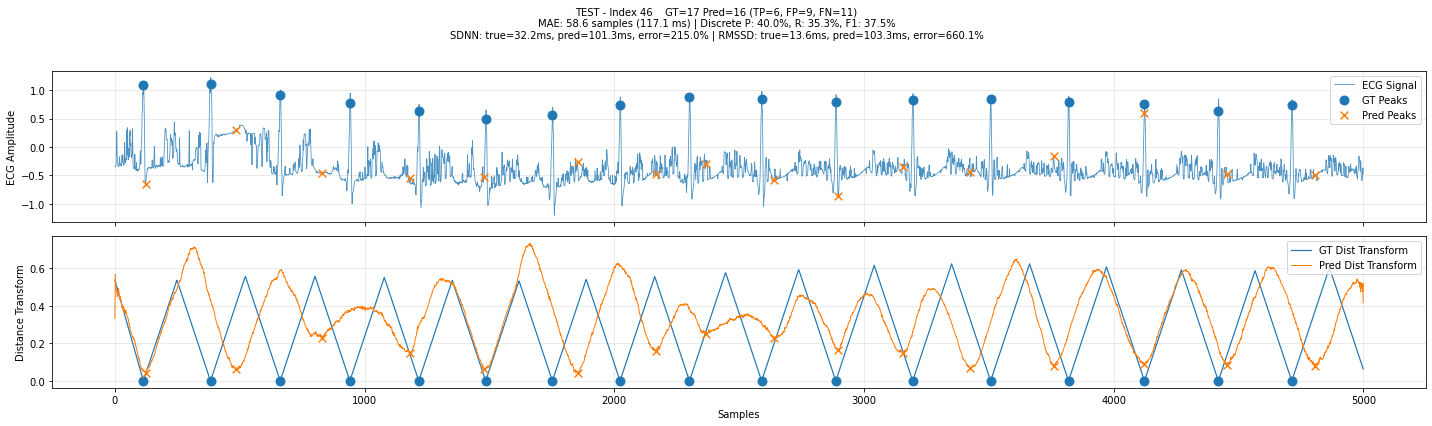

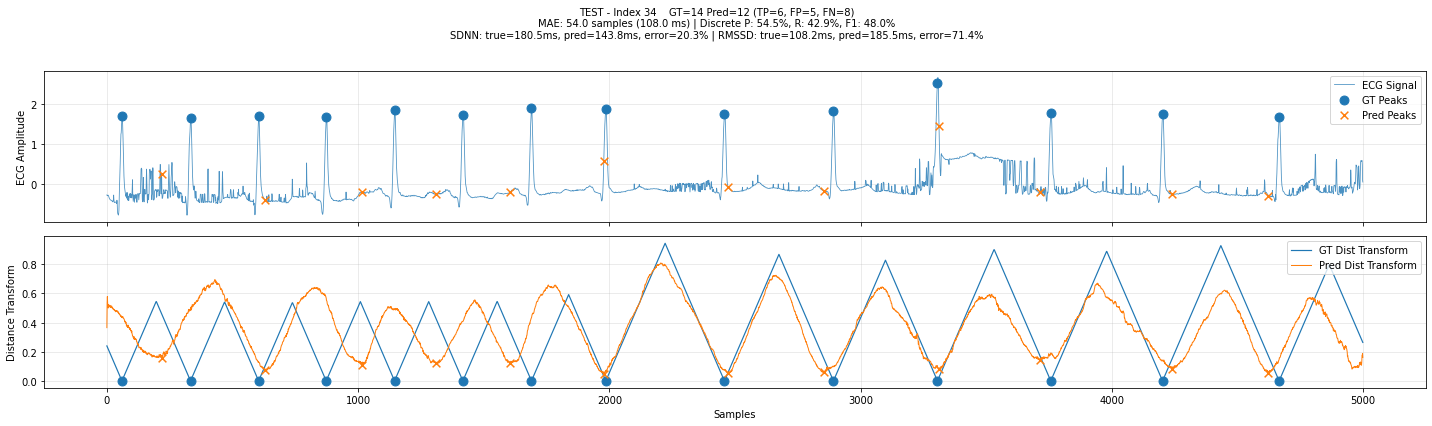

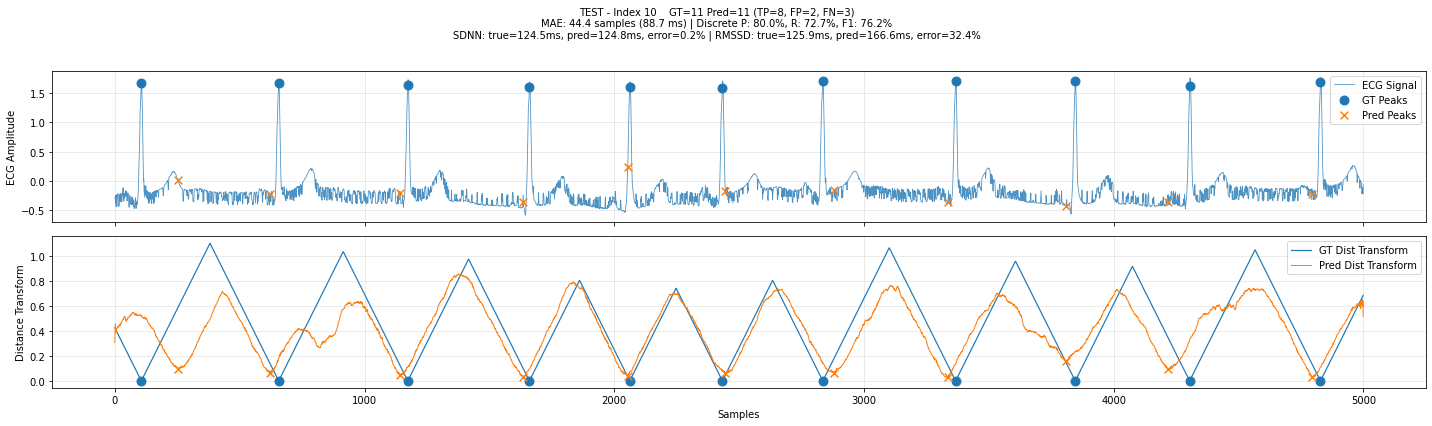

In [ ]:
#print("TRAIN SET Peak Detection Examples:")
#visualize_peak_detection(trainloader, model, device, n_samples=5, dataset_name="TRAIN")

print("\nTEST SET Peak Detection Examples:")
visualize_peak_detection(testloader, model, device, n_samples=5, dataset_name="TEST")

In [ ]:
summary_per_subject(model, testloader, trainloader, valloader, device)

Computing per-subject metrics for all datasets...



PER-SUBJECT METRICS - TEST SET
 Subject_ID  Num_Segments    MAE_s  Precision   Recall       F1  Disc_P_%  Disc_R_%  Disc_F1_%  mRR_err_%  pRR50_err_%  SDRR_err_%  RMSSD_err_%
         27            44 0.157676   0.646222 0.640744 0.642392 28.219243 26.331509  27.189768   6.317421    45.936008  219.991940   331.550194
         28            42 0.228230   0.507556 0.525252 0.513850 17.382868 17.759582  17.510202  15.464230    54.532280  245.205918   369.693233
         29            46 0.099561   0.800805 0.806975 0.802452 69.213830 68.006577  68.496668   6.167420    21.417345   59.101385   101.409667
         30            46 0.128815   0.614080 0.518045 0.560429 38.968387 32.106254  35.125941  12.985967    64.284737  380.082159   635.521509
         33            42 0.059189   0.867917 0.876334 0.871405 81.651959 79.346645  80.429965   2.021135    23.706175   78.392507   106.964669
         35            49 0.136662   0.669315 0.663609 0.665470 44.913360 43.037209  43.900741   6.41212